### 3.1 MNIST

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape
y.shape

(70000,)

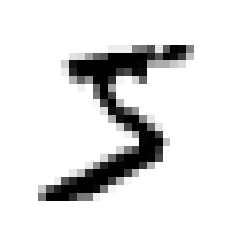

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
y[0]

'5'

In [6]:
# y를 정수로 변환
import numpy as np
y = y.astype(np.uint8)

In [7]:
#훈련데이터, 검증데이터 나누기
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 3.2 이진 분류기 훈련

In [7]:
# 5를 식별하는 분류기
y_train_5 = (y_train == 5) # 5는 true, 다른 숫자는 모두 false
y_test_5 = (y_test == 5)

In [8]:
# 확률적 경사 하강법(Stochastic Gradient Descent, SGD)
# SGDClassifier는 훈련하는 데 무작위성을 사용함.

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
sgd_clf.predict([some_digit]) #첫 번째 행 데이터

array([ True])

### 3.3 성능 측정

#### 3.3.1 교차 검증을 사용한 정확도 측정

##### 교차 검증 구현

가끔 사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어할 필요가 있음. 아래의 코드는 사이킷런의 cross_val_score() 함수와 거의 같은 작업을 수행하고 동일한 결과를 출력함.

##### StrarifiedFold

target에 속성값의 개수를 동일하게 가져감으로써 kfold 같이 데이터가 한곳으로 몰리는 것을 방지함. 즉 레이블값의 분포를 반영하여 데이터를 분할한다.

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
 
skfolds = StratifiedKFold(n_splits = 3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold) #올바른 예측의 수
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


##### cross_val_score()

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

위에서 정확도가 좋아보이지만 아래에서 모든 데이터를 '5아님'으로 분류하는 모델을 만들어보고자 함.(나이브 벤치마크)

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

위의 결과에서 모든 예측값을 '5아님'으로 해도 90%를 넘어서는 것을 볼 수 있다. 이 예제를 통해 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 알 수 있다. 특히 불균형한 데이터셋을 다룰때 더욱 그렇다.

#### 3.3.2 오차행렬

##### cross_val_predict
k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환함. 즉, 훈련세트의 모든 샘플에 대해 깨끗한 예측을 얻게 된다 ( 여기서 깨끗하다는 뜻은 모델이 훈련하는 동안 보지 못했던 데이터에 대해 예측했다는 뜻이다.)

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

##### confusion_matrix()
행은 실제 값, 열은 예측값을 나타낸다.

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [16]:
# 완벽한 분류기
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

##### 정밀도(precision)
##### 재현율(recall) = 민감도(sensitivity) = 진양성(true positive)

#### 3.3.3 정밀도와 재현율

사이킷런은 정밀도와 재현율을 포함하여 분류기의 지표를 계산하는 여러 함수를 제공

In [17]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) #정밀도

0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred) #재현율

0.6511713705958311

##### F1점수(f1-score)
정밀도와 재현율의 조화평균

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### 3.3.4 정밀도/재현율 트레이드오프

SGDClassifier는 결정함수(decision function)을 사용하여 각 샘플의 점수를 계산함. 

##### decision_function()

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [21]:
threshold = 0 #임계값
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([ True])

In [22]:
threshold = 8000
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([False])

적절한 임계값을 구하는 방법?
##### cross_val_predict()
훈련 세트에 있는 모든 샘플의 점수를 구해야 함. 예측 결과가 아닌 결정 점수를 반환받도록 지정

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

##### precision_recall_curve()

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

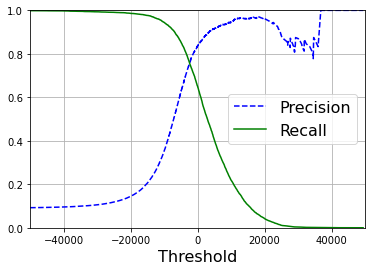

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

위의 그림에서 precision이 재현율 곡선보다 왜 더 울퉁불퉁한지 의아할 수 있다.이는 임계값을 올리더라도 정밀도가 가끔 낮아질때가 있기 때문이다. 반면 재현율은 임곗값이 올라감에 따라 줄어들 수 밖에 없다. 정밀도의 분모는 임계값에 따라 달라지기 때문이다.

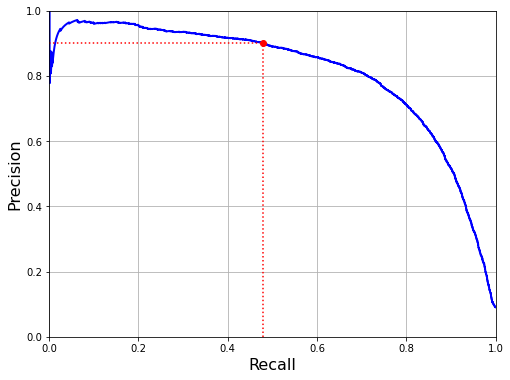

In [26]:
#### 재현율에 대한 정밀도 곡선
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
#save_fig("precision_vs_recall_plot")
plt.show()

#### 그외의 함수
##### average_precision_score()
##### plot_precision_recall_curve()

In [27]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [28]:
threshold_90_precision

3370.0194991439557

In [29]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [30]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [31]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

=> 재현율이 너무 낮다면 높은 정밀도의 분류기는 전혀 유용하지 않다.

#### 3.3.5 ROC 곡선

##### ROC(receiver operating characteristics, 수신기 조작 특성)
: 거짓 양성 비율(false positive rate)에 대한 진짜 양성 비율(true positive rate)의 곡선

: 민감도에 대한 1-특이도 그래프

##### roc_curve()

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

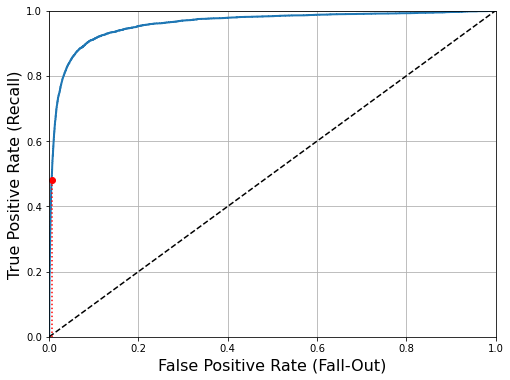

In [33]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], "k--") #대각 점선
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True) 
    
plt.figure(figsize=(8, 6))    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
#save_fig("roc_curve_plot")  
plt.show()

##### AUC(area under the curve)
:완벽한 분류기는 AUC가 1, 완전한 랜덤 분류기는 0.5임

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

##### ROC 곡선과 PR
ROC 곡서이 정밀도/재현율(PR) 곡선과 비슷해서 어떤 것을 사용해야 할지 궁금할 수 있음. 일반적으로는 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 PR곡선을 사용하고, 그렇지 않으면 ROC곡선을 사용한다.

예를 들어 위의 ROC 곡선은 매우 좋은 분류기로 보이지만, 이는 음성에 비해 양성이 매우 적기 때문이다. 이와는 달리 PR곡선은 분류기의 성능 개선 여지가 얼마나 되는지 잘 보여줌. 

##### randomforest와 SGDClassifier 비교

##### dicision_function()
##### predict_proba()

In [35]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                   method="predict_proba")

In [36]:
# roc_curve는 레이블과 점수를 기대하지만, 점수 대신 클래스 확률을 전달할 수 있다.
y_scores_forest = y_probas_forest[:,1] #양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

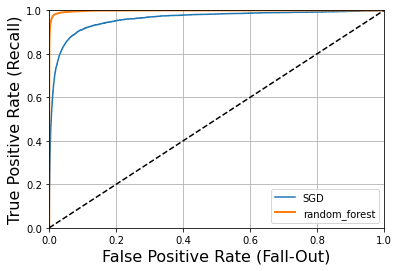

In [37]:
plt.plot(fpr, tpr, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "random_forest")
plt.legend(loc="lower right")
plt.show()

In [38]:
#랜덤 포레스트의 roc 곡선이 더 왼쪽 위로 가있다.
# 그럼 AUC는?
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### 3.4 다중 분류

#### 다중 분류기(multiclass classifier) = 다항 분류기(mulinomial classifier)

1. SGD분류기, 랜덤 포레스트 분류기, 나이브 베이즈 분류기 와 같은 일부 알고리즘은 여러 개의 클래스를 직접 처리할 수 있다.

2. 로지스틱 회귀, 서포트 벡터 머신 분류기 같은 다르 알고리즘은 이진 분류만 가능하다.

하지만 이진 분류기를 열 개 사용해 다중 클래스를 분류하는 기법이 존재함.

##### ORV(one-versus-the-rest), OvA(one-versus-all)
특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템을 만들 수 있음. 이미지를 분류할 때는 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택하면 됨.

##### OvO(one-versus-one)
0과 1구별, 0과 2구별, ... 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련(10C2 개). 이후 가장 많이 양성으로 분류된 클래스를 선택, OvO 전략의 장점은 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요함

서포트 벡터 머신 같은 일부 알고리즘은 훈련 세트의 크기에 민감해서 큰 훈련 세트에서 몇 개의 분류기를 훈련시키는 것보다 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빠르므로 OvO를 선호함. 하지만 대부분의 이진 분류 알고리즘에서는 OvR을 선호한다.

다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면, 사이킷런이 알고리즘에 따라 자동으로 OvR or OvO를 실행함.

In [39]:
# 내부에서는 OvO를 실행하여 각각의 결정계수를 얻고 점수가 가장 높은 클래스를 선택함.
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [40]:
# 샘플당 10개의 점수를 반환함.
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [41]:
np.argmax(some_digit_scores)

5

분류기가 훈련될 때 classes_속성에 타깃 클래스의 리스트를 값으로 정렬하여 저장함.

In [42]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 OneVsOneClassifier 나 OneVsRestClassifier를 사용함. 이진 분류기 인스턴스를 만들고 객체를 생성할 때 전달하면 됨.

In [43]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [44]:
len(ovr_clf.estimators_)

10

SGDClassifier 를 훈련시키는 것도 간단함. SGD 분류기는 직접 샘플을 다중 클래스로 분류함.

In [45]:
sgd_clf.decision_function([some_digit])

array([2164.22030239])

In [46]:
#교차검증
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [47]:
# 간단하게 입력의 스케일을 조정
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### 3.5 에러 분석

In [ ]:
# 에러의 종류를 분석
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

위의 오차행렬은 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋아보임. 숫자 5는 다른 숫자보다 조금 더 어두워 보이는데, 이는 숫자 5의 이미지가 적거나, 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻이다.

In [ ]:
#에러의 비율 비교
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0) #주대각선을 0으로 채움
plt.matshow(norm_conf_mx, cmap=plt.cm.grey)
plt.show()

1. 많은 이미지가 8로 잘못분류됨
2. 3,5가 혼동되고 있음

개선 방향
1. 8처럼 보이는 다른 값들의 데이터를 더 모아서 학습시킨다.
2. 분류기에 도움이 될만한 특성을 더 찾아본다.

In [ ]:
# 3, 5의 에러 분석
cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]


## 연습문제

In [8]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights = 'distance', n_neighbors = 4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [10]:
y_knn_pred = knn_clf.predict(X_test)

In [11]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

In [12]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28,28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

NameError: name 'plot_digit' is not defined

In [ ]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1,0), (-1, 0), (0,1),(0,-1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_Train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)
    
X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

In [ ]:
knn_clf.fit(X_train_expanded, y_train_expanded)

In [ ]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_knn_expanded_pred)

In [ ]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

In [ ]:
plot_digit(ambiguous_digit)

### 1. 97% 정확도 달성하기

In [ ]:
# 16시간 걸림
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

### 2. 데이터를 한 픽셀씩 이동하는 함수

In [ ]:
from scipy.ndimage.interpolation import shift

In [ ]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [ ]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [ ]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [ ]:
knn_clf.fit(X_train_augmented, y_train_augmented)

In [ ]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)